# 数理モデル解析特論 第4回

このコードの実行の前に以下のパッケージをインストールする必要がある。

```
using Pkg
Pkg.add("IJulia")
Pkg.add("Plots")
Pkg.add("IntervalArithmetic")

```

## 数値計算に潜むリスク

- 整数、浮動小数点数
- 数値計算に生じる誤差
- 区間演算


## そもそも数値計算とは？
* 数値計算（数値解析）とは…数学の問題を有限桁の浮動小数点数を使って「数値的」に解く．数式処理とは違う
* 数値計算でできること，できないこと
* 数値計算は誤差との戦い
* 整数（integer）と浮動小数点数（binary32/binary64）

## 整数型
Juliaで整数は

|型| 機械内表現 |
|:-----------|:----------|
| Int8    | 8bit整数  |
| Int16    | 16bit整数  |
| Int32    | 32bit整数  |
| Int64   | 64bit整数 |
| Int128   | 128bit整数 |
| BigInt   | 任意精度 |


のような数値がある．

In [1]:
a = Int32(10)

10

In [2]:
b = Int32(2147483647) + Int32(1)

-2147483648

In [3]:
c = typemax(Int32)

2147483647

In [4]:
x = Int32(139)
y = Int32(954)
z = Int32(2115)
if x ^ 3 + y ^ 3 == z ^ 3
    println("Counter example of Fermat's theorem")
    println("(x, y, z) = ($x, $y, $z)")
end

Counter example of Fermat's theorem
(x, y, z) = (139, 954, 2115)


これからInt32の最大値が2147483647であることがわかり
$2^{31}-1=2147483647$
である．

説明のために32bit整数（Int32）を考えると

|ビットパターン | 数値 |
|:-----------:|:----------:|
|01111111111111111111111111111111 | 2147483647|
|00000000000000000000000000000010 | 2|
|00000000000000000000000000000001 | 1|
|00000000000000000000000000000000 | 0|
|11111111111111111111111111111111 | -1|
|11111111111111111111111111111110 |-2|
|10000000000000000000000000000000 |-2147483648|

このような負の数の表現形式を「**2の補数形式**」と呼ぶ．
32個の各bitが次のような重みをもっていると考えられる．

$$\fbox{$-2^{31}$}\fbox{$2^{30}$}\fbox{$2^{29}$}\,\cdots\fbox{$2^{1}$}\fbox{$2^{0}$}$$

2の補数形式の場合，$n$ビットで $-2^{n-1}$〜$2^{n-1}-1$の範囲の数を表現できる．つまり

|型|表現範囲|
|:-|:-:|
|Int8|-128〜127|
|Int16|-32768〜32767|
|Int32|-2147483648〜2147483647|
|Int64|-9223372036854775808〜9223372036854775807|
|Int128|-170141183460469231731687303715884105728〜170141183460469231731687303715884105727|

の範囲の整数が表せる．


In [5]:
x = (139)
y = (954)
z = (2115)
if x ^ 3 + y ^ 3 == z ^ 3
    println("Counter example of Fermat's theorem")
    println("(x, y, z) = ($x, $y, $z)")
end

In [6]:
2147483647+1

2147483648

In [7]:
9223372036854775807+1

-9223372036854775808

## 浮動小数点数

**浮動小数点数**（Float64/double, Float32/float）は，「浮動小数点形式」と呼ばれる形式で表現できる．

例えば，「$1234.5$」を「$1.2345\times 10^3$」のように， 小数点の位置を1番左の数値と左から2番目の数値の間に移動（「正規化」と呼ぶ）し，それに指数を掛けた形式で数を表現する．
この「$1.2345$」の部分を「仮数部」，「$10^3$」の部分（厳密には$~^3$）を「指数部」という．

浮動小数点数は仮数部の長さ，指数部の長さ，基数が2，10，16など，多様な規格が考えられる．
そこで1985年にWilliam Kahanが中心となって

[IEEE 754: Standard for Binary Floating-Point Arithmetic](https://ja.wikipedia.org/wiki/IEEE_754)

という標準規格が制定された．最近では世に出るハードウェアのほぼ全てがこの規格に従っている．

### 倍精度 (Float64/double, binary64)
倍精度は，符号（$\pm$）に1ビット．指数部に11ビット，仮数部に 52ビットを使う．
全部で64ビット=8バイトである．

$\fbox{1（符号）}\fbox{11（指数部）}\fbox{52（仮数部）}$

* 符号は，0なら正，1なら負
* 指数部は「$\times 2^{\mbox{指数}}$」の指数の部分に$1023$を加えたものが11ビット符号無しの整数の形で格納されている
* 仮数部は，実際の仮数部の先頭の「1」を取り除いた残りが格納されている．仮数部の先頭は必ず1にしてメモリに格納しないことで1ビット分精度を稼いでいる

数値$x$は

$$x=\pm\; 1.d_1d_2\cdots d_{52}\times 2^{m}=\pm\left(\frac{1}{2^0}+\frac{d_1}{2^1}+\frac{d_2}{2^2}+\cdots+\frac{d_{52}}{2^{52}}\right)2^{e}_{(10)}$$

と書ける（$-1022\le e\le 1023$，$m$：$e+1023$の2進表現）．

例えば，5.25は2進数で書くと
$$
	101.01_{(2)} = \left(\frac{1}{2^0}+\frac{0}{2^1}+\frac{1}{2^2}+\frac{0}{2^{3}}+\frac{1}{2^4}\right)\times 2^2_{(10)}
$$
であるから，計算機内では

$\fbox{0}\fbox{10000000001}\fbox{0101000000000000000000000000000000000000000000000000}$

のように格納されている。指数部の「1000000001」は、「2+1023=1025」 を2進数にしたもの．

これは**正規化数**と呼ばれる数の範囲．

実際にJuliaのbitstring関数を使って浮動小数点数を見てみよう．

In [8]:
x = 5.25
println(bitstring(x))
println(bitstring(5.24))

0100000000010101000000000000000000000000000000000000000000000000
0100000000010100111101011100001010001111010111000010100011110110


In [4]:
binx = bitstring(x) 
sign = binx[1]; println(sign)
expo = binx[2:12]; println(expo)
frac = binx[13:end]; println(frac)

0
10000000001
0101000000000000000000000000000000000000000000000000


符号はsign = 0で正の数, 指数部はexp-1023=1025-1023=**2**，  
仮数部はfrac=(101000000000000000000000000000000000000000000000000)$_2$で2進数表示され，実際の値は**1.3125**，  
元の浮動小数点数に戻すと

$$(-1)^{\mathrm{sign}}*\mathrm{frac}*2^{\mathrm{expo}-1023}=5.25$$

で次のように確かに元の数に戻ることがわかる．

In [5]:
aa = [parse(Int, f) for f in frac]
bb = 2. .^(1:52)
dfrac = 1 + sum(aa ./ bb); println(dfrac)
cc = [parse(Int, f) for f in expo]
dexp = sum(cc .* (2 .^(10:-1:0))) - 1023; println(dexp)
x = (-1)^(parse(Int,sign))*dfrac*2^(dexp); println(x)

1.3125
2
5.25


次に$e$の範囲$-1022\le e\le 1023$に注目する．

$e+1023$が11ビット符号無しの整数なら範囲は$0$〜$2047$であるが，$e$範囲から
$e+1023=0$のときと$e+1023=2047$のときが使われていない．

これらは**特殊な数を表す**のに使われる．それらは

* 零
* 無限大 (Inf)
* NaN (Not a Number)
* 非正規化数

と呼ばれる．

#### 零
指数部が$e+1023=0$かつ仮数部が0のとき.

$$\pm\; 0.00\cdots 0\times 2^{0}={\pm\left(\frac{0}{2^0}+\frac{0}{2^1}+\frac{0}{2^2}+\cdots+\frac{0}{2^{52}}\right)2^{-1023}}_{(10)}.$$




In [9]:
x = 0.0; println(x); println(bitstring(x))
x = -0.0; println(x); println(bitstring(x))

0.0
0000000000000000000000000000000000000000000000000000000000000000
-0.0
1000000000000000000000000000000000000000000000000000000000000000


#### 無限大
$e+1023=2047$かつ仮数部が0のとき，$\pm\infty$を表す．

$$\pm\; 1.00\cdots 0\times 2^{m}={\pm\left(\frac{1}{2^0}+\frac{0}{2^1}+\frac{0}{2^2}+\cdots+\frac{0}{2^{52}}\right)2^{1024}}_{(10)},$$

$m$: 2047の2進表現. このとき**オーバーフロー**が起こるという.

In [9]:
x = Inf; println(x); println(bitstring(x))
println(-x); println(bitstring(-x))
println(2.0^(1024))

Inf
0111111111110000000000000000000000000000000000000000000000000000
-Inf
1111111111110000000000000000000000000000000000000000000000000000
Inf


#### NaN (Not a Number)
$e+1023=2047$かつ仮数部が0でないとき．

負数の平方根など，不可能な演算の結果を表すのに使われる．

In [11]:
x = Inf; println(bitstring(x))
x = NaN; println(x); println(bitstring(x))
x = Inf - Inf; println(x); println(bitstring(x))
x = Inf / Inf; println(x); println(bitstring(x))

0111111111110000000000000000000000000000000000000000000000000000
NaN
0111111111111000000000000000000000000000000000000000000000000000
NaN
0111111111111000000000000000000000000000000000000000000000000000
NaN
0111111111111000000000000000000000000000000000000000000000000000



#### 正規化数の最大最小
正の正規化数の最大の数は，$e+1023=2046$, かつ仮数部のビットが全て1のとき．

$${\left(\frac{{1}}{2^0}+\frac{1}{2^1}+\frac{1}{2^2}+\cdots+\frac{1}{2^{52}}\right)2^{{1023}}}_{(10)}= 2^{1024}-2^{971}\approx10^{308.25}$$

であり，これを1ビットでも超えたら無限大になる．これを**オーバーフロー**という．



In [12]:
x = (2. ^ 53 - 1) * 2. ^ 971
println(x)
println(bitstring(x))
x = (2. ^ 53) * 2. ^ 971
println(x)
println(bitstring(x))

1.7976931348623157e308
0111111111101111111111111111111111111111111111111111111111111111
Inf
0111111111110000000000000000000000000000000000000000000000000000


正の正規化数の最小の数は，$e+1023=1$, かつ仮数部のビットが全て0のとき．

$${\left(\frac{{1}}{2^0}+\frac{0}{2^1}+\frac{0}{2^2}+\cdots+\frac{0}{2^{52}}\right)2^{-1022}}_{(10)}= 2^{-1022}\approx10^{-307.65}$$

であり，これを下回ると**アンダーフロー**というが，IEEE 754 では，ここでアンダーフローさせないで仮数部を使った「悪あがき」をする．次の例を見てみよう.

In [13]:
x = 2. ^ (-1022)
println(x)
println(bitstring(x))
y = x-2^(-1074);
println(y)
println(bitstring(y))

2.2250738585072014e-308
0000000000010000000000000000000000000000000000000000000000000000
2.225073858507201e-308
0000000000001111111111111111111111111111111111111111111111111111


#### 非正規化数
指数部が$e+1023=0$かつ仮数部が0でないとき，

仮数部の最初の桁を$0$にして

$$\pm\; 0.d_1d_2\cdots d_{52}\times 2^{0}={\pm\left(\frac{\color{red}0}{2^0}+\frac{d_1}{2^1}+\frac{d_2}{2^2}+\cdots+\frac{d_{52}}{2^{52}}\right)2^{{\color{red}{-1022}}}}_{(10)}.$$

という数の表現をする．つまり指数部が$e+1023=1$よりも小さくなったら、正規化しないで指数部は$e+1023=1$のままにする. 代わりに仮数部の最初の桁を$0$にする.
このような決まりによって, 非正規化数は文字通り「正規化していない」数となる．

#### 漸近アンダーフロー
上の例のように正規化数の最小数の最終bitを1だけ減らすと

$${\left(\frac{{0}}{2^0}+\frac{1}{2^1}+\frac{1}{2^2}+\cdots+\frac{1}{2^{52}}\right)2^{-1022}}_{(10)}$$

となり，これを正規化すると

$${\left(\frac{{1}}{2^0}+\frac{1}{2^1}+\frac{1}{2^2}+\cdots+\frac{0}{2^{52}}\right)2^{-1023}}_{(10)}$$

となって，指数部の下限$-1022\le e$を超えてしまう．
そこで，「$2^{-1022}$を下回ったら正規化をやめて指数部を$2^{-1022}$に固定して仮数部の最初の桁を0としてみて格納する」ルールが発動し, 非正規化数での数の表現が始まる.
以下, 1ビットずつ減らしていくと

$${\left(\frac{{0}}{2^0}+\frac{1}{2^1}+\frac{1}{2^2}+\cdots+\frac{1}{2^{52}}\right)2^{-1022}}_{(10)}$$
$${\left(\frac{{0}}{2^0}+\frac{1}{2^1}+\frac{1}{2^2}+\cdots+\frac{0}{2^{52}}\right)2^{-1022}}_{(10)}$$
$$\vdots$$
$$\left(\frac{{0}}{2^0}+\frac{1}{2^1}+\frac{0}{2^2}+\cdots+\frac{0}{2^{52}}\right)2^{-1022}$$
$${\left(\frac{{0}}{2^0}+\frac{0}{2^1}+\frac{1}{2^2}+\cdots+\frac{1}{2^{52}}\right)2^{-1022}}_{(10)}$$
$$\vdots$$
$${\left(\frac{{0}}{2^0}+\frac{0}{2^1}+\frac{0}{2^2}+\cdots+\frac{1}{2^{52}}\right)2^{-1022}}_{(10)}=2^{-1074}\approx10^{-323.31}$$

のような数が表現できる．ただし，$2^{-1022}$と$2^{-1074}$の間の数は，本来53ビットあるべき仮数部の長さが52ビット〜1ビットまで減ってしまっており，精度が低下していることに注意が必要である．

In [10]:
x = 2. ^ (-1074)
println(x)
println(bitstring(x))

x = (2. ^ (-1074)) / 2
println(x)
println(bitstring(x))

5.0e-324
0000000000000000000000000000000000000000000000000000000000000001
0.0
0000000000000000000000000000000000000000000000000000000000000000


### 浮動小数点数まとめ

倍精度(binary64, Float64/double)は

||仮数部が0|仮数部が0でない|
|:-:|:-:|:-:|
|$e+1023=0$            | $\pm0$      | 非正規化数|
|$1\le e+1023\le 2046$ | 正規化数     | 正規化数 |
|$e+1023=2047$         | $\pm\infty$ | NaN|


単精度 (binary32, Float32/float) は


||仮数部が0|仮数部が0でない|
|:-:|:-:|:-:|
|$e+127=0$            | $\pm0$      | 非正規化数|
|$1\le e+127\le 254$ | 正規化数     | 正規化数 |
|$e+127=255$         | $\pm\infty$ | NaN|

今後，浮動小数点数全体の集合を$\mathbb{F}$と表すことにする．特に断りがなければ，浮動小数点数は倍精度浮動小数点数（64bit）とする．IEEE754では**binary64**とも呼ばれている．



## 丸め誤差
浮動小数点数を使用した演算に混入する誤差について述べる

浮動小数点数同士の演算（加減乗除など）の結果は，浮動小数点数で表せるとは限らない．
例えば，10進数で仮数部3桁の浮動小数点演算を考え，2/3を計算すると，

$$
	2.00\times 10^0/3.00\times 10^0=0.66666666...\times 10^0
$$

となり，仮数部3桁に収まらない．仮数部の4桁目で四捨五入を行うと

$$
	6.67\times10^{-1}
$$

となる．このときの計算値と真値との差

$$
	6.67\times10^{-1}-6.6666666...\times10^{-1}=3.3333333...\times10^{-4}
$$

が丸め誤差である．

IEEE 754は2進数浮動小数点数なので，基本的には0捨1入で丸められる．
例えば，10進数の「0.1」をIEEE 754のbinary64に変換してみると

\begin{align*}
	0.1_{(10)} &= 0.000110011001100110011..._{(2)}\\
	& = 1.10011001100110011...\times 2^{m},
\end{align*}

$m$は$-4+1023=1019$の2進表現，つまり$m=01111111011$.
仮数部は無限小数になっているのでそのまま格納出来ない．
小数点以下を 52bit以内とそれ以降で区切って表示すると

$\fbox{1001100110011001100110011001100110011001100110011001}\fbox{10011001100....}$

となり，はみ出た部分の先頭が「1」なので、0捨1入で繰り上げる．
最終的には， 10進数の「0.1」は

$\fbox{0}\fbox{01111111011}\fbox{1001100110011001100110011001100110011001100110011010}$

のように格納されている．

In [11]:
x = 0.1
println(bitstring(x))

0011111110111001100110011001100110011001100110011001100110011010


10進数の0.1は計算機には正確に格納できず，少しだけ0.1より大きい値で格納されており，
**丸め誤差**が含まれている

$$
    \displaystyle\frac{1}{10}\approx{\color{red}{0.1000000000000000}}055511151231257827021181583404541015625
$$

In [12]:
using Printf
@printf("%.55f", x)

0.1000000000000000055511151231257827021181583404541015625

さらに, 0.1を逐次的に加えていくと計算結果は丸め誤差の影響により, 不可解な計算結果を返す事がある.

In [13]:
println(bitstring(0.1 + 1.1))
println(bitstring(1.2))

0011111111110011001100110011001100110011001100110011001100110100
0011111111110011001100110011001100110011001100110011001100110011


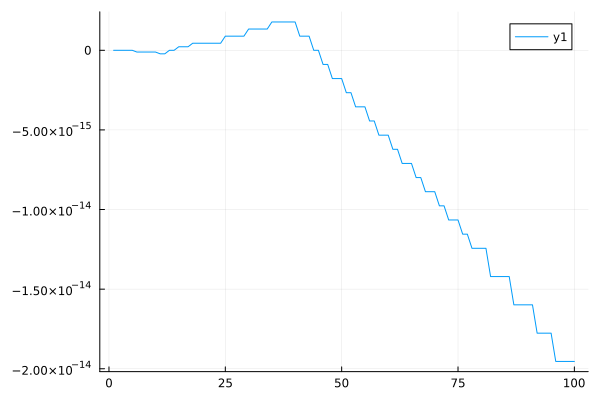

In [37]:
x = 0.0
itr_num = 100
result = zeros(itr_num)
for i = 1:itr_num
    x += 0.1
    result[i] = x
end
# @printf("%.55f\n", x)
# println(bitstring(x))
# println(bitstring(10.))
using Plots
f(x) = 0.1x
# plot(f,1,itr_num)
plot(result .- [f(x) for x in 1:itr_num])

## 丸めの制御

IEEE754では，4つの丸めモードを用意している．$\tilde{x}$を実数（$\tilde{x}\in\mathbb{R}$）とする．いま実数 $\tilde x$ が

$$\tilde x=\pm\left(\frac{1}{2^0}+\frac{d_1}{2^1}+\frac{d_2}{2^2}+\dots\right)2^{e}_{(10)}$$

であるときに，その近似

$$x=\pm\left(\frac{1}{2^0}+\frac{d_1}{2^1}+\frac{d_2}{2^2}+\cdots+\frac{d_{52}}{2^{52}}\right)2^{e}_{(10)}\in\mathbb{F}$$

を採用する丸めは**原点方向への丸め**（切り捨て）と呼ばれている．

また $\tilde x$ の近似として誤差$|x-\tilde{x}|$の値が最小になる$x\in\mathbb{F}$，すなわち

$$
    |x-\tilde{x}|=\min_{y\in\mathbb{F}}|y-\tilde{x}|
$$

をみたす$x\in\mathbb{F}$を採用する方法を**最近点への丸め**という．しかし $\tilde x$ が2つの浮動小数点数

$$
    x_1=\left(\frac{1}{2^0}+\frac{d_1}{2^1}+\frac{d_2}{2^2}+\cdots+\frac{d_{52}}{2^{52}}\right)2^{e}_{(10)},~~~x_2=\left(\frac{1}{2^0}+\frac{d_1}{2^1}+\frac{d_2}{2^2}+\cdots+\frac{d_{52}+1}{2^{52}}\right)2^{e}_{(10)}
$$

の中点となると$|x_1-\tilde{x}|=|x_2-\tilde{x}|$が成り立ち，$x$は一つに決まらない．このときは**仮数部の最後のビットが0**になる方に丸めが実行される．これを**最近偶数への丸め**という．


In [18]:
eps = 2. ^ (-52) # unit round off
x = 1. + eps/4.
@printf("%.50f\n", x)
println(bitstring(x))

y = 1. + 3*(eps/4.)
@printf("%.50f\n", y)
println(bitstring(y))

z = 1. + (eps/2.)
@printf("%.50f\n", z)
println(bitstring(z))

1.00000000000000000000000000000000000000000000000000
0011111111110000000000000000000000000000000000000000000000000000
1.00000000000000022204460492503130808472633361816406
0011111111110000000000000000000000000000000000000000000000000001
1.00000000000000000000000000000000000000000000000000
0011111111110000000000000000000000000000000000000000000000000000


In [19]:
x = 2.
@printf("%.50f\n", x)
println(bitstring(x))

y = 2. - eps
@printf("%.50f\n", y)
println(bitstring(y))

z = 2. - eps/2.
@printf("%.50f\n", z)
println(bitstring(z))

2.00000000000000000000000000000000000000000000000000
0100000000000000000000000000000000000000000000000000000000000000
1.99999999999999977795539507496869191527366638183594
0011111111111111111111111111111111111111111111111111111111111111
2.00000000000000000000000000000000000000000000000000
0100000000000000000000000000000000000000000000000000000000000000


次は$\tilde{x}$よりも必ず大きな$a\in\mathbb{F}$，すなわち

$$
    a=\min\left\{x\in\mathbb{F}:x\ge\tilde{x}\right\}
$$

をみたす$a\in\mathbb{F}$を採用する方法を$+\infty$**方向への丸め**（上向き丸め）という．逆に$\tilde{x}$よりも必ず小さな$b\in\mathbb{F}$，すなわち

$$
    b=\max\left\{x\in\mathbb{F}:x\le\tilde{x}\right\}
$$

をみたす$b\in\mathbb{F}$を採用する方法を$-\infty$**方向への丸め**（下向き丸め）という．これらより

$$ b\le\tilde{x}\le a $$

が常に成立する．特に精度保証付き数値計算ではこの2つの丸めモードを利用することで，*厳密な包含*を得ることができるようになる．まとめると

* 最近点への丸め（デフォルト）：$\tilde{x}$ に最も近い浮動小数点数に丸める．もし2点あるならば仮数部の最後のビットが0である浮動小数点数に丸める．
* $+\infty$方向への丸め：$\tilde{x}$ 以上の浮動小数点数の中で最も小さい浮動小数点数に丸める．
* $-\infty$方向への丸め：$\tilde{x}$ 以下の浮動小数点数の中で最も大きい浮動小数点数に丸める．
* 原点方向への丸め：絶対値が $\tilde{x}$ 以下の浮動小数点数の中で，$\tilde{x}$ に最も近いものに丸める．

## その他の誤差いろいろ

丸め誤差は実数を浮動小数点数で近似する際の誤差であった．ここでは浮動小数点数を用いた演算のその他の問題点を紹介する．

### 桁落ち
極めて近い数どうしの減算によって，誤差が著しく大きくなってしまう現象．
2つの浮動小数点数

$$
    x=\left(\frac{1}{2^0}+\frac{d_1}{2^1}+\dots+\frac{d_p}{2^p}+\frac{1}{2^{p+1}}+\cdots+\frac{b_{p+2}}{2^{p+2}}+\dots+\frac{b_{52}}{2^{52}}\right)2^{e}_{(10)},
$$
$$
    y=\left(\frac{1}{2^0}+\frac{d_1}{2^1}+\dots+\frac{d_p}{2^p}+\frac{0}{2^{p+1}}+\cdots+\frac{c_{p+2}}{2^{p+2}}+\dots+\frac{c_{52}}{2^{52}}\right)2^{e}_{(10)}
$$

が$x>y$とし，仮数部の最初から $p$ ビットが等しいとする．このとき

$$
    x-y=\left(\frac{1}{2^0}+\frac{b_{p+2}-c_{p+2}}{2^1}+\dots+\frac{b_{52}-c_{52}}{2^{52-p-1}}\right)2^{e-p-1}_{(10)}
$$

これよりもともと $52$ 個あった仮数部の情報が，$52-p$ 個に減っている．例を挙げよう．

$b>0$とし，2次方程式 $x^2+bx+c=0$の解の公式

$$
    x_1=\frac{-b+\sqrt{b^2-4c}}{2},\quad x_2=\frac{-b-\sqrt{b^2-4c}}{2}
$$

を考える．いまもしも$b^2\gg c$となるならば，$b$ と $\sqrt{b^2-4c}$が近い数になるので，$x_1$の分子の計算で，桁落ちが起こる．

In [20]:
b = 1e+15
c = 1e+14

x1 = (-b + sqrt(b^2 - 4c)) / 2
println(x1)
println(x1^2 + b*x1 + c)

x2 = 2c / (-b - sqrt(b^2 - 4*c))
println(x2)
println(x2^2 + b*x2 + c)

-0.125
-2.4999999999999984e13
-0.10000000000000002
0.0


### 情報落ち
絶対値の大きさが極端に違う2 数の加減算を行った時，小さいほうの数値の下位の桁が失われてしまう現象．

In [21]:
println((3.14159265358979+1e10)-1e10)
println(3.14159265358979 + (1e10-1e10))

3.141592025756836
3.14159265358979


In [22]:
println(1e48+543.2-1e48-1e36+123.4+1e36)
println(1e48-1e48-1e36+1e36+543.2+123.4)
println(1e48-1e36-1e48+1e36+543.2+123.4)

0.0
666.6
-3.9230984419161617e30


## 打ち切り誤差
無限回行うべき計算を有限回の計算で置き換えることにより生じる誤差．計算機は有限回の四則演算しかできない．そのため，無限級数や収束列のような値を求めるためには，有限項で打ち切った近似値を用いる．その際に誤差が生じる．

（例）Taylor展開の打ち切り誤差，Newton法の打ち切り誤差，数値積分の打ち切り誤差

In [23]:
function exp_taylor(x) # naive implementation of "exp" function
    s = 0.0
    t = 1.0
    i = 1
    while true
        s += t
        if abs(t) < abs(s) * 1e-15
            break
        end
        t *= x / i
        i += 1
    end
    return s
end
println(exp_taylor(20.))
println(exp(20.))
println(exp_taylor(-20.))
println(exp(-20.))

4.851651954097903e8
4.851651954097903e8
6.147561828914626e-9
2.061153622438558e-9


# 区間演算

区間の表現，区間演算について述べる．精度保証付き数値計算の基本的な原理は，実数値で与えられる真の値の上限と下限を浮動小数点数により浮動小数点演算を用いて包み込むことである．

$\mathbb{R}$上の区間を
$$
	\boldsymbol{a}:=\{x\in\mathbb{R}:\underline{a}\le x\le\overline{a},~\underline{a}, \overline{a}\in\mathbb{R}\}=[\underline{a}, \overline{a}]
$$

と表し，区間の全体を$\mathbb{IR}$とする．
この時 $\underline{a}$ を区間の下端，$\overline{a}$ を区間の上端という．
さらに区間の

$$
\begin{array}{ll}
\mbox{直径（diameter）:}&\mathrm{d}(\boldsymbol{a})=\overline{a}-\underline{a}\in\mathbb{R}\\
\mbox{半径（radious）:}&\mathrm{rad}(\boldsymbol{a})=\frac{\overline{a}-\underline{a}}{2}\in\mathbb{R}\\
\mbox{中点（center）:}&\mathrm{mid}(\boldsymbol{a})=\frac{\overline{a}+\underline{a}}{2}\in\mathbb{R}\\
\mbox{最小絶対値:}&\mathrm{mig}(\boldsymbol{a})=\min\{|a|:a\in\boldsymbol{a}\}\in\mathbb{R}\\
\mbox{最大絶対値:}&\mathrm{mag}(\boldsymbol{a})=\max\{|a|:a\in\boldsymbol{a}\}\in\mathbb{R}\\
\end{array}
$$

をそれぞれ表すとする．

Juliaで区間を扱うために[IntervalArithmetic.jl](https://github.com/JuliaIntervals/IntervalArithmetic.jl)パッケージを使う.

In [38]:
using IntervalArithmetic

a = interval(-2, 1)
# a = -2. .. 1.    # .. operator
println(a)

print("d(a)   = ")
println(diam(a))

print("rad(a) = ")
println(radius(a))

print("mid(a) = ")
println(mid(a))

print("mig(a) = ")
println(mig(a))

print("mag(a) = ")
println(mag(a))

# @format midpoint 3
# @format full
# @format standard 10

Interval{Float64}(-2.0, 1.0, com)
d(a)   = 3.0
rad(a) = 1.5
mid(a) = -0.5
mig(a) = 0.0
mag(a) = 2.0


## 区間演算（上端下端型）

区間$\boldsymbol{X}=[a,b]$, $\boldsymbol{Y}=[c,d]$に対して，四則演算を定義する：

\begin{align*}
	\boldsymbol{X}+\boldsymbol{Y}&=[a+c,b+d]\\
	\boldsymbol{X}-\boldsymbol{Y}&=[a-d,b-c]\\
	\boldsymbol{X}\times\boldsymbol{Y}&=[\min\{ac,ad,bc,bd\},\max\{ac,ad,bc,bd\}]\\
	\boldsymbol{X}\div\boldsymbol{Y}&=[\min\{a/c,a/d,b/c,b/d\},\max\{a/c,a/d,b/c,b/d\}]
\end{align*}

$\times,~\div$は場合分けをする．

||$c>0$|$0\in\boldsymbol{Y}$|$d<0$|
|:-------------:|:-------------:|:---------------:|:-------------:|
|$a>0$|$[ac,bd]$|$[bc,bd]$|$[bc,ad]$|
|$0\in\boldsymbol{X}$|$[ad,bd]$|$A$|$[bc,ac]$|
|$b<0$|$[ad,bc]$|$[ad,ad]$|$[bd,ac]$|

ただし $A=[\min\{ad,bc\},\max\{ad,bc\}].$

注：区間内全ての要素について演算を行うため無限回の計算が必要のように思えるが，これをまとめて実現するのが区間演算．さらに除算で割る区間$\boldsymbol{Y}$に0が含まれる（$0\in\boldsymbol{Y}$）と演算結果は無限大を含むことになる．


In [39]:
X = interval(-2, 1)
Y = interval(1, 3)

println(X + Y)
println(X - Y)
println(X * Y)
println(X / Y)
println(Y / X)

Interval{Float64}(-1.0, 4.0, com)
Interval{Float64}(-5.0, 0.0, com)
Interval{Float64}(-6.0, 3.0, com)
Interval{Float64}(-2.0, 1.0, com)
Interval{Float64}(-Inf, Inf, trv)


包含関係の単調性が成立する．すなわち $\boldsymbol{X}_1\subseteq \boldsymbol{X}_2$ かつ $\boldsymbol{Y}_1\subseteq \boldsymbol{Y}_2$ ならば $\boldsymbol{X}_1\circ\boldsymbol{Y}_1\subseteq \boldsymbol{X}_2\circ\boldsymbol{Y}_2$ が成立する．ここで，$\circ\in\{+,-,\times,\div\}$とする．

さらに $+$, $\times$ に関しては，交換則と結合則が成立する．

$$
    \boldsymbol{X}\circ\boldsymbol{Y}=\boldsymbol{Y}\circ\boldsymbol{X},~\boldsymbol{X}\circ(\boldsymbol{Y}\circ\boldsymbol{Z})=(\boldsymbol{X}\circ\boldsymbol{Y})\circ\boldsymbol{Z},\quad\circ\in\{+,\times\}.
$$

しかし，加法と乗法の逆元は存在しない．すなわち分配則が成立しない．劣分配則のみ成立する．

$$
    \boldsymbol{X}(\boldsymbol{Y}+\boldsymbol{Z})\subseteq\boldsymbol{X}\boldsymbol{Y}+\boldsymbol{X}\boldsymbol{Z}.
$$

In [41]:
X = interval(-1, 1)
Y = interval(1, 2)
Z = interval(-2, 1)

println(X * (Y + Z))
println(X * Y + X * Z)
println(isinterior(X * (Y + Z) , X * Y + X * Z))

Interval{Float64}(-3.0, 3.0, com)
Interval{Float64}(-4.0, 4.0, com)
true


## 中心半径型区間演算

上端下端型区間の他に区間を中心と半径で表す型もある．それを**中心半径型区間**という．中心半径型（mid-rad 型）区間は実数 $x\in\mathbb{R}$ に対して，区間の中心を $x_c$，半径を $x_r$ としたとき

$$
    \boldsymbol{x}=\langle x_c,x_r\rangle=\left\{x:x_c-x_r\le x\le x_c+x_r\right\}
$$

と表される．中心半径型区間と上端下端型区間の間には次のような関係が成り立つ：

$$
    \boldsymbol{x}=[\underline{x},\overline{x}]=[x_c-x_r,x_c+x_r]=\left\langle\frac{\underline{x}+\overline{x}}{2},\frac{\underline{x}-\overline{x}}{2}\right\rangle=\langle x_c,x_r\rangle=\boldsymbol{x}
$$

中心半径型区間 $\boldsymbol{x}=\langle x_c,x_r\rangle$, $\boldsymbol{y}=\langle y_c,y_r\rangle$ に対して，四則演算を定義する．

\begin{align*}
    \boldsymbol{x}+\boldsymbol{y}&=\langle x_c+y_c,x_r+y_r\rangle\\
    \boldsymbol{x}-\boldsymbol{y}&=\langle x_c-y_c,x_r+y_r\rangle\\
    \boldsymbol{x}\times\boldsymbol{y}&\subseteq\langle x_cy_c,|x_c|y_r+|y_c|x_r+x_ry_r\rangle\\
    \boldsymbol{x}\div\boldsymbol{y}&=\frac{\boldsymbol{x}\times\boldsymbol{y}}{\underline{y}\overline{y}}=\frac{\boldsymbol{x}\times\boldsymbol{y}}{y_c^2-y_r^2}
\end{align*}

ちなみに乗算は$\mathop{sgn}(\cdot)$を括弧内の符号を返す関数とすると

$$
    \boldsymbol{x}\times\boldsymbol{y}=\langle x_cy_c+\delta_1,\delta_2\rangle
$$

と書ける．ここで

$$
    \delta_1=\mathop{sgn}(x_cy_c)\min\left\{x_r|y_c|,|x_c|y_r,x_ry_r\right\}
$$
$$
\delta_2=\max\left\{x_r(|y_c|+y_r),(|x_c|+x_r)y_r,x_r|y_c|+|x_c|y_r\right\}
$$

である．

In [46]:
X = interval(0, 1,format=:midpoint)
Y = interval(1.5, 0.5, format=:midpoint)
Z = interval(-0.5, 1.5,format=:midpoint)

# @format midpoint 3
println(X + Y)
println(X - Y)
println(X * Y)
println(X / Y)

Interval{Float64}(0.0, 3.0, com)
Interval{Float64}(-3.0, 0.0, com)
Interval{Float64}(-2.0, 2.0, com)
Interval{Float64}(-1.0, 1.0, com)


## 関数の値域評価

$ \boldsymbol{I}\in\mathbb{IR}$をある区間とし，$f:D\subset\mathbb{R}\to\mathbb{R}$を領域 $D$ で連続な関数とする．
このとき関数 $f$ は $\mathbb{IR}$ 上の関数として拡張できる．

$$
	f(\boldsymbol{I})=\{f(x):x\in\boldsymbol{I}\}
$$

この $f(\boldsymbol{I})$ は関数の値域で，これを厳密に計算することは非線形関数の場合不可能である．よって

$$
	f(\boldsymbol{I})\subseteq [a,b]
$$

となる区間 $[a,b]$ で関数の値域を包含する．これを $f$ の区間 $\boldsymbol{I}$ における**区間拡張**（区間拡張は一意的でないことに注意！）といい，$f_{[\,]}(\boldsymbol{I})=[a,b]$ と表す．

**注意**　IEEE 754 標準規格における丸めに従っているのは「**四則演算・平方根**」だけ．それ以外の関数（例えば，$\sin$，$\cos$ などは）丸めの向きの
変更が不可能（**自作するか，丸めに対応し作成されたものを使う**こと）．ただし，デフォルトの関数も精度が十分に高く作られているため，精度保証などを考えない場合はそれで十分．

### 例

例えば，関数 $f(x)=x^2+2x$ を考える．関数に区間を単純に代入すると
\begin{align*}
	x&\in[0.9,1.1]\\
	x^2&\in[0.81,1.21]\\
	2x&\in[1.8,2.2]\\
	x^2+2x&\in[2.61,3.41]\\
\end{align*}

Interval{Float64}(2.6099999999999994, 3.4100000000000006, com)


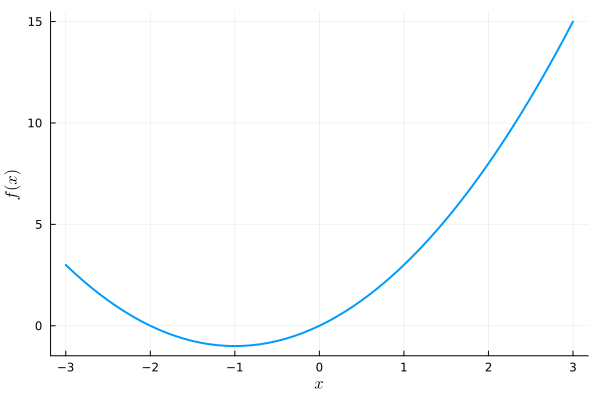

In [64]:
# @format standard 5
using Plots

function f(x)
    return x.^2 + 2x
end

function f(x::Interval{Float64})
    return x^interval(2) + interval(2)*x
end


x = range(-3, 3, step = 0.1);
y = f(x);

println(f(interval(I"0.9",I"1.1")))
plot(x, y, xlabel="\$x\$", ylabel="\$f\\,(x)\$", linewidth =2, legend = false)

In [65]:
println(f(0.9))
println(f(1.1))

2.6100000000000003
3.41


$f(x)=x^2+2x$ のときは値域評価が区間拡張を利用しても精度が良い．一方で

$f(x)=x^2-2x$;

\begin{align*}
	x&\in[0.9,1.1]\\
	x^2&\in[0.81,1.21]\\
	2x&\in[1.8,2.2]\\
	x^2-2x&\in[-1.39,-0.59]\mbox{（幅0.8!）}\\
\end{align*}


Interval{Float64}(-1.3900000000000003, -0.5899999999999994, com)
-1
-0.99


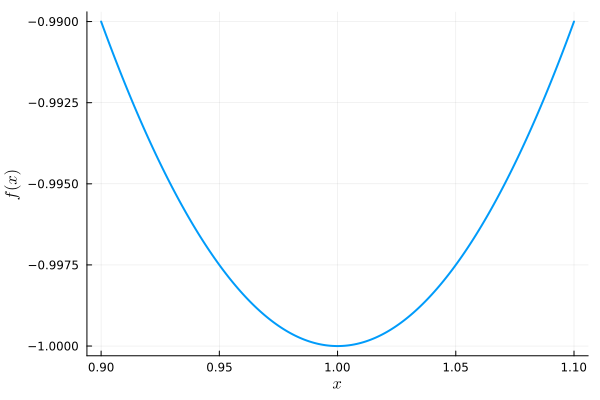

In [66]:
function f(x)
    return x.^2 - 2x
end

function f(x::Interval{Float64})
    return x^interval(2) - interval(2)*x
end


x = range(0.9, 1.1, step=0.001);
y = f(x);

println(f(interval(I"0.9",I"1.1")))
println(f(1))
println(f(1.1))

plot(x, y, xlabel="\$x\$", ylabel="\$f\\,(x)\$", linewidth =2, legend = false)

これから値域は $[-1,-0.99]$，一方で区間演算による区間拡張は $[-1.39,-0.59]$．だいぶ過大評価になってしまう．そこで区間幅を改良したい

**アイディア1.** $f(x)=x(x-2)$;

\begin{align*}
	&x\in[0.9,1.1]\\
	&x(x-2)=[0.9,1.1]\times[-1.1,-0.9]=[-1.21,-0.81]\mbox{（幅0.4）}
\end{align*}

大分改善された．もう一声！

**アイディア2.** $f(x)=(x-1)^2-1$;

\begin{align*}
	x\in[0.9,1.1]&\\
	(x-1)^2-1=&[-0.1,0.1]^2-1\\
	=&[{\color{red}{0}},0.01]-1\\
	=&[-1,-0.99]\mbox{（幅0.01）}
\end{align*}

In [69]:
x = interval(I"0.9", I"1.1")

i2 = interval(2)
println(x^i2 - i2*x)
println(x * (x-i2))
println((x-interval(1))^i2 - interval(1))

Interval{Float64}(-1.3900000000000003, -0.5899999999999994, com)
Interval{Float64}(-1.2100000000000004, -0.8099999999999998, com)
Interval{Float64}(-1.0, -0.9899999999999999, com)


**注意**　区間の定義で、実数を端点にする時は`I"0.1"`などを使う。端点が浮動小数点の場合は`interval`でOK. `interval`の方が呼び出しは早い。例えば、0.1を含む区間は`interval`での定義では0.1に一番近い浮動小数点数を端点にもつ点区間が返されて、厳密な包含にならない。

In [75]:
@time x = interval(0.1)
println(bitstring(0.1))
println(bitstring(inf(x)))
println(bitstring(sup(x)))

@time x = (I"0.1")
println(bitstring(0.1))
println(bitstring(inf(x)))
println(bitstring(sup(x)))


  0.000000 seconds
0011111110111001100110011001100110011001100110011001100110011010
0011111110111001100110011001100110011001100110011001100110011010
0011111110111001100110011001100110011001100110011001100110011010
  0.000001 seconds
0011111110111001100110011001100110011001100110011001100110011010
0011111110111001100110011001100110011001100110011001100110011001
0011111110111001100110011001100110011001100110011001100110011010


Interval{Float64}(1.988546365851573, 2.440000000000001, com)
Interval{Float64}(-Inf, 2.939882026094574, trv)


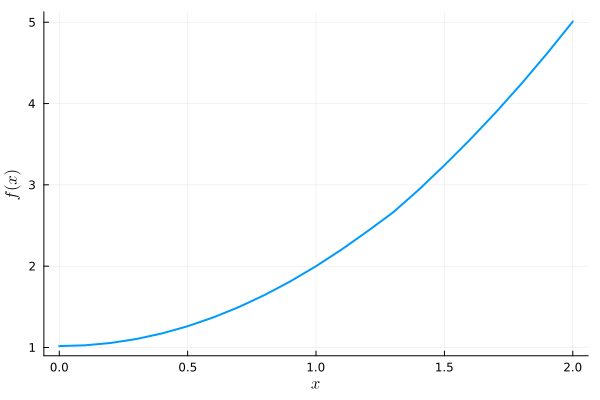

In [87]:
# Kahan's example
f(x) = (1/80) * log(abs(3*(1 - x) + 1)) + x.^2 + 1
f(x::Interval{Float64}) = (interval(1)/interval(80)) * log(abs(interval(3)*(interval(1) - x) + interval(1))) + x^interval(2) + interval(1)
x = range(0, 2, step = 0.1)
y = f.(x)

println(f(interval(I"1.0",I"1.2")))
println(f(interval(1.3,1.4)))
plot(x, y, xlabel="\$x\$", ylabel="\$f\\,(x)\$", linewidth =2, legend = false)

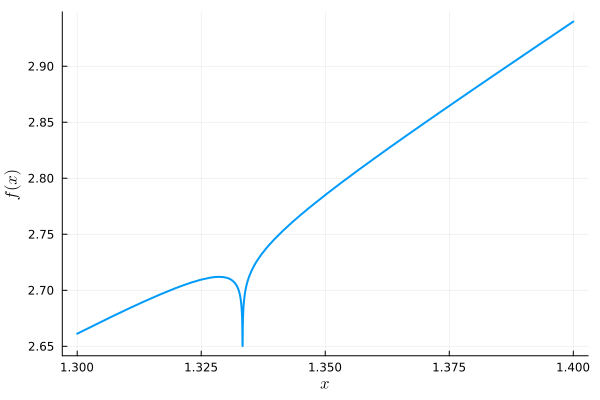

In [81]:
plot(f, 1.3, 1.4, xlabel="\$x\$", ylabel="\$f\\,(x)\$", linewidth =2, legend = false)

### 区間幅の抑制のための工夫

1. **区間分割**
$$
	\boldsymbol{I}=\boldsymbol{I}_1\cup\boldsymbol{I}_2
$$
と考えて，$f_{[\,]}(\boldsymbol{I}_1)\cup f_{[\,]}(\boldsymbol{I}_2)$を計算する．

1. **平均値形式**  
区間拡張$f_{[\,]}(\boldsymbol{I})$を
$$
	f_{[\,]}(\boldsymbol{I})=f(c)+f'_{[\,]}(\boldsymbol{I})(\boldsymbol{I}-c),~c=\mathrm{mid}(\boldsymbol{I})
$$
によって得る．ただし$f'_{[\,]}(\boldsymbol{I})$は区間$\boldsymbol{I}$における$f$の1階微分の区間拡張．



## 機械区間演算

区間演算をコンピュータで実現するには$\mathbb{R}$の代わりに$\mathbb{F}$を使った区間が必要．そのような区間全体を

$$
	\mathbb{IF}:=\{\boldsymbol{x}\in\mathbb{IR}: \underline{x},~\overline{x}\in\mathbb{F}\}
$$

と定義する．IEEE754規格に準拠したシステム上では演算後の丸めの向きを制御することができる．
演算結果が浮動小数点数でない場合，丸めの向きを制御して計算する．
いま$a,b\in\mathbb{F}$に対して，$\circ\in\{+,-,\times,\div\}$として

\begin{align*}
	\mathtt{fl}_{\bigtriangledown}\!\left(a\circ b\right)&:=\max\{x\in\mathbb{F}:x\le a\circ b\}\mbox{（下向き丸め）}\\
	\mathtt{fl}_{\bigtriangleup}\!\left(a\circ b\right)&:=\min\{x\in\mathbb{F}:x\ge a\circ b\}\mbox{（上向き丸め）}
\end{align*}

とすると

$$
	\mathtt{fl}_{\bigtriangledown}\!\left(a\circ b\right)\le a\circ b\le\mathtt{fl}_{\bigtriangleup}\!\left(a\circ b\right)
$$

が成立する．

$\boldsymbol{X}=[a,b]$, $\boldsymbol{Y}=[c,d]$ ($a,b,c,d\in\mathbb{F}$)に対して，機械区間演算は次のように実現できる．

\begin{align*}
	\boldsymbol{X}+\boldsymbol{Y}&=[\mathtt{fl}_{\bigtriangledown}\!\left(a+c\right),\mathtt{fl}_{\bigtriangleup}\!\left(b+d\right)]\\
	\boldsymbol{X}-\boldsymbol{Y}&=[\mathtt{fl}_{\bigtriangledown}\!\left(a-d\right),\mathtt{fl}_{\bigtriangleup}\!\left(b-c\right)]\\
	\boldsymbol{X}\times\boldsymbol{Y}&=[\mathtt{fl}_{\bigtriangledown}\!\left(\min\{ac,ad,bc,bd\}\right),\mathtt{fl}_{\bigtriangleup}\!\left(\max\{ac,ad,bc,bd\}\right)]\\
	\boldsymbol{X}\div\boldsymbol{Y}&=[\mathtt{fl}_{\bigtriangledown}\!\left(\min\{a/c,a/d,b/c,b/d\}\right),\mathtt{fl}_{\bigtriangleup}\!\left(\max\{a/c,a/d,b/c,b/d\}\right)]
\end{align*}


|$\boldsymbol{X}\times\boldsymbol{Y}$|$c>0$|$0\in\boldsymbol{Y}$|$d<0$|
|:-------------:|:-------------:|:-------------:|:-------------:|
|$a>0$|$[\mathtt{fl}_{\bigtriangledown}\!\left(ac\right),\mathtt{fl}_{\bigtriangleup}\!\left(bd\right)]$|$[\mathtt{fl}_{\bigtriangledown}\!\left(bc\right),\mathtt{fl}_{\bigtriangleup}\!\left(bd\right)]$|$[\mathtt{fl}_{\bigtriangledown}\!\left(bc\right),\mathtt{fl}_{\bigtriangleup}\!\left(ad\right)]$|
|$0\in\boldsymbol{X}$|$[\mathtt{fl}_{\bigtriangledown}\!\left(ad\right),\mathtt{fl}_{\bigtriangleup}\!\left(bd\right)]$|$B$|$[\mathtt{fl}_{\bigtriangledown}\!\left(bc\right),\mathtt{fl}_{\bigtriangleup}\!\left(ac\right)]$|
|$b<0$|$[\mathtt{fl}_{\bigtriangledown}\!\left(ad\right),\mathtt{fl}_{\bigtriangleup}\!\left(bc\right)]$|$[\mathtt{fl}_{\bigtriangledown}\!\left(ad\right),\mathtt{fl}_{\bigtriangleup}\!\left(ad\right)]$|$[\mathtt{fl}_{\bigtriangledown}\!\left(bd\right),\mathtt{fl}_{\bigtriangleup}\!\left(ac\right)]$|

ただし $B=[\min\{\mathtt{fl}_{\bigtriangledown}\!\left(ad\right),\mathtt{fl}_{\bigtriangledown}\!\left(bc\right)\},\max\{\mathtt{fl}_{\bigtriangleup}\!\left(ad\right),\mathtt{fl}_{\bigtriangleup}\!\left(bc\right)\}].$

## ベクトル・行列の区間演算

上で述べた丸めの向きを制御することにより，ベクトル $x,y\in\mathbb{F}^n$ の内積 $x^Ty$，行列 $A, B\in\mathbb{F}^n$ の積，あるいは，ベクトル行列積 $Ax$ の結果を区間で厳密に包含することができる．

$$
	\mathtt{fl}_{\bigtriangledown}\!\left(x^Ty\right)\le x^Ty\le\mathtt{fl}_{\bigtriangleup}\!\left(x^Ty\right)
$$

$$
	\mathtt{fl}_{\bigtriangledown}\!\left(Ax\right)\le Ax\le\mathtt{fl}_{\bigtriangleup}\!\left(Ax\right)
$$

$$
	\mathtt{fl}_{\bigtriangledown}\!\left(AB\right)\le AB\le\mathtt{fl}_{\bigtriangleup}\!\left(AB\right)
$$

このようにすると丸め方向の制御で区間演算が容易にできる．しかし，行列ベクトル積，行列積を高速に実装することは職人芸のレベルの難しさである（例えば，キャシュサイズをみて最適なブロック分割などを行う）．そのため通常は数値計算ライブラリを利用するのが主流である．

**注意**　Juliaでは現状、丸め方向の制御ができない。従って、上で紹介しているような区間演算ができない（と思う）。丸め方向を指定してBLASを使った区間演算とかはできない模様（本当？）。現状は各演算を区間演算にした演算が以下のようにできている。

`IntervalArithmetic.jl`を利用すると半ば強引に丸めの向きを制御できる。

In [35]:
setrounding(Float64, RoundUp)
xup = parse(Float64, "0.1") * parse(Float64, "0.2")

setrounding(Float64, RoundDown)
xdown = parse(Float64, "0.1") * parse(Float64, "0.2")

setrounding(Float64, RoundNearest)

@show xup
@show xdown
xup > xdown

xup = 0.020000000000000004
xdown = 0.019999999999999993


true

しかしながら、BLASを利用する丸め向きの制御には（今の所）失敗している。

In [40]:
for n = 63:66
    @show n
    A, B = randn(n,n), randn(n,n)
    setrounding(Float64, RoundUp) # RoundUp
    Cup = A*B;
    setrounding(Float64, RoundDown) # RoundDown
    Cdown = A*B;
    setrounding(Float64, RoundNearest) # RoundNearest
    # Cnearest = A*B;
    @show all(Cup .> Cdown)
end

n = 63
all(Cup .> Cdown) = true
n = 64
all(Cup .> Cdown) = true
n = 65
all(Cup .> Cdown) = false
n = 66
all(Cup .> Cdown) = false


In [41]:
using LinearAlgebra
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libopenblas64_.dylib

丸めの向きを制御しているので、必ず大小関係が成立しているはずであるが、$n=65$からは上向き丸め、下向き丸めの計算結果が同じになるケースが発生する。これでは精度保証ができているとは言えない。これはBLASが原因であることが知られているが、現状、対策がない。唯一、Intel CPUでMKLを使っているケースのみ成功することが観測されている。

In [42]:
using MKL
for n = 63:66
    @show n
    A, B = randn(n,n), randn(n,n)
    setrounding(Float64, RoundUp) # RoundUp
    Cup = A*B;
    setrounding(Float64, RoundDown) # RoundDown
    Cdown = A*B;
    setrounding(Float64, RoundNearest) # RoundNearest
    # Cnearest = A*B;
    @show all(Cup .> Cdown)
end

n = 63
all(Cup .> Cdown) = true
n = 64
all(Cup .> Cdown) = true
n = 65
all(Cup .> Cdown) = false
n = 66
all(Cup .> Cdown) = false


In [43]:
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libopenblas64_.dylib

私のラップトップ環境（Apple siliconチップ）ではMKLは使えなかった。。

In [44]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.2.0)
  CPU: Apple M1 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, cyclone)


In [45]:
using Pkg; Pkg.status("IntervalArithmetic")

      Status `~/.julia/environments/v1.7/Project.toml`
  [d1acc4aa] IntervalArithmetic v0.20.3


In [30]:
using SetRoundingLLVM

struct Interval{T <: Number}
    lo::T
    hi::T
end

# import Base: *
# import Base.: +
# import Base: -
# import Base: /

function +(a::Interval{T}, b::Interval{T}) where T <: Real
    llvm_setrounding(RoundDown) do
        lo = a.lo + b.lo
    end
    llvm_setrounding(RoundUp) do
        hi = a.hi + b.hi
    end
    Interval{T}(lo, hi)
end

function -(a::Interval{T}, b::Interval{T}) where T <: Real
    llvm_setrounding(RoundDown) do
        lo = a.lo - b.hi
    end
    llvm_setrounding(RoundUp) do
        hi = a.hi - b.lo
    end
    Interval{T}(lo, hi)
end

function *(a::Interval{T}, b::Interval{T}) where T <: Real
    llvm_setrounding(RoundDown) do
        lo = min(a.lo * b.lo, a.lo * b.hi, a.hi * b.lo, a.hi * b.hi)
    end
    llvm_setrounding(RoundUp) do
        hi = max(a.lo * b.lo, a.lo * b.hi, a.hi * b.lo, a.hi * b.hi)
    end
    Interval{T}(lo, hi)
end

function /(a::Interval{T}, b::Interval{T}) where T <: Real
    llvm_setrounding(RoundDown) do
        lo = min(a.lo / b.lo, a.lo / b.hi, a.hi / b.lo, a.hi / b.hi)
    end
    llvm_setrounding(RoundUp) do
        hi = max(a.lo / b.lo, a.lo / b.hi, a.hi / b.lo, a.hi / b.hi)
    end
    Interval{T}(lo, hi)
end



/ (generic function with 1 method)

In [31]:

X = Interval(1.,2.)
Y = Interval(-1.,2.)


@show X + Y

LoadError: MethodError: no method matching +(::Float64, ::Float64)
You may have intended to import Base.:+

### 謝辞

本資料は教員が学生の頃に精度保証付き数値計算の諸論を教えて下さった[柏木雅英](http://www.kashi.info.waseda.ac.jp/~kashi/)先生の「数値解析特論」の講義資料が基になっています.
また, 以下のような文献・Web ページ等を参考にこの文章は書いています.

### 参考文献

1. 伊理正夫, 藤野和建, 数値計算の常識, 共立出版, 1985.<br>
(Twitterとかでも度々話題に上がる名著. IEEE754 の制定の年にすでに浮動小数点数に対する注意が詰まっている書籍が出版されている. 桁落ち, 情報落ちなどの誤差に詳しい)
1. 齊藤宣一, 数値解析入門, 東京大学出版会, 2012.<br>
(数値解析学の現在最も詳しい教科書)
1. 大石進一編著, 精度保証付き数値計算の基礎, コロナ社, 2018.<br>
(精度保証付き数値計算の教科書. 浮動小数点数および区間演算に詳しい. この1章が読めたら大したもの)
1. [ushiostarfish, IEEE 754 浮動小数点入門.](https://ushiostarfish.hatenablog.com/entry/2019/08/12/210023)<br>
(IEEE 754 浮動小数点数を細かく紹介し, 丸め誤差の詳細, および区間演算について触れている)
1. Nick Higham, [What Is Floating-Point Arithmetic](https://nhigham.com/2020/05/04/what-is-floating-point-arithmetic/)/[IEEE Standard Arithmetic](https://nhigham.com/2020/05/07/what-is-ieee-standard-arithmetic/).<br>
(数値解析の超有名人によるブログ記事, (IEEE754/854)浮動小数点数について端的にまとめられている)
1. Nick Higham, [What Is Rounding?](https://nhigham.com/2020/04/28/what-is-rounding/).<br>
    (数値解析の超有名人によるブログ記事, 丸めについて端的にまとめられている)
1. [Calculating with sets: Interval methods in Julia](https://github.com/dpsanders/IntervalsJuliaCon2020).<br>
(Juliaで区間演算をするJuliaCon2020のチュートリアル資料、[動画](https://youtu.be/LAuRCy9jUU8)も公開されている)
1. [IntervalArithmetic.jl: Basic usage](https://github.com/JuliaIntervals/IntervalArithmetic.jl/blob/master/docs/src/usage.md).<br>
(IntervalArithmetic.jlの区間演算の説明ページ)
1. matsueushi, [デフォルトの丸めモードで上付き丸め、下付き丸めをエミュレートする(Julia)](https://matsueushi.github.io/posts/rounding-emulator/).<br>
(IntervalArithmetic.jlの丸め変更はこれを使用しているようです)
1. matsueushi, [Juliaで丸めモードを指定して浮動小数点数の計算をする(したい)](https://matsueushi.github.io/posts/julia-rounding/).<br>
(丸めモードの指定ができない！？最近点丸めだけで区間演算しないといけないのか...)